# Classification of WBCs into Polynuclear and Mononuclear cells
### Architecture Used: 18-layered RESNET CNN network
### Metrics Used: ROC/AUC, Training/Validation Accuracy
### Final Model type: h5

In [124]:
# Load important modules
import keras
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import random as random
from skimage.transform import resize


UsageError: Line magic function `%` not found.


In [125]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(20)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

### EDA on images and channels

All the these images are RGB images and they would constitute three channels - one for each of the color channels

Monocytes and Lymphocytes have been clubbed together in a folder for mononuclear images

Eosinophils and Neutrophills have been clubbed together in a folder for polynuclear images

In [126]:
# path to your dataset
# Customize the dataset path for your environment
DATASET_PATH = r'C:\Users\pankaj.kharwal\Desktop\hackathon\blood_smear_data'

# Monocytes and Lymphocytes have been clubbed together in a folder for 'mononuclear' images
# Eosinophils and Neutrophills have been clubbed together in a folder for 'polynuclear' images
# mononuclear and polynuclear will be the 2 classes
smear_cls = ['mononuclear', 'polynuclear']

In [127]:
# Use glob to get jpeg contents of the dataset path
smear_path = os.path.join(DATASET_PATH, smear_cls[1], '*.jpeg')
print(smear_path)

# glob through the directory (returns a list of all file paths)
smear_path = glob.glob(smear_path)

C:\Users\pankaj.kharwal\Desktop\hackathon\blood_smear_data\polynuclear\*.jpeg


# EDA on the image dataset

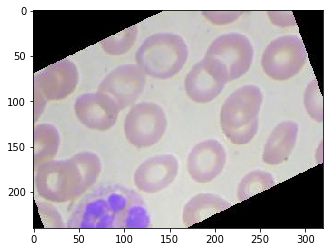

In [128]:
# look at some randomly chosen images of blood smears
import random
rand_index = random.randint(0, len(smear_path))

image = io.imread(smear_path[rand_index])
plt.imshow(image)

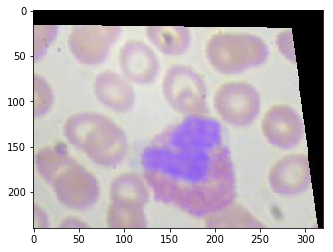

In [129]:
# plot a sample image
smear_path = os.path.join(DATASET_PATH, smear_cls[1], '*')
smear_path = glob.glob(smear_path)

# access some element (a file) from the list
image = io.imread(smear_path[21])
plt.imshow(image)

### View the image in single channels to analyze if the strains are distinctively depictable in individual channels

Text(0.5,0.98,'Different Channels of Image')

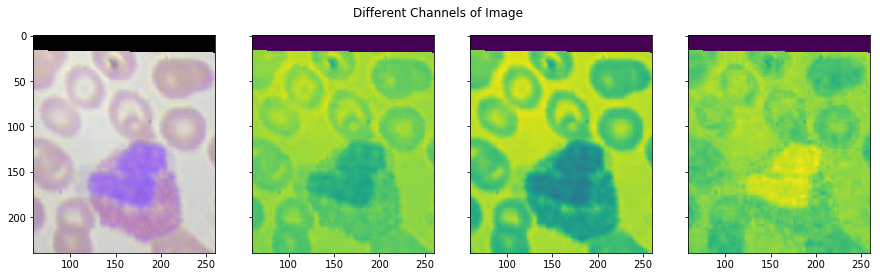

In [130]:
# plotting the original image and the RGB channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(15)
ax1.imshow(image)

# RGB channels
ax2.imshow(image[:, : , 0])
ax3.imshow(image[:, : , 1])
ax4.imshow(image[:, : , 2])
f.suptitle('Different Channels of Image')

##### We can see that the images are not having clear cut boundaries of stained target cells in individual channels. Hence we need to consider all channels for modelling purposes

## Morphological Transformations

### Thresholding

Let's take a threshold and see the effect of that on sample images. This results in a binary image

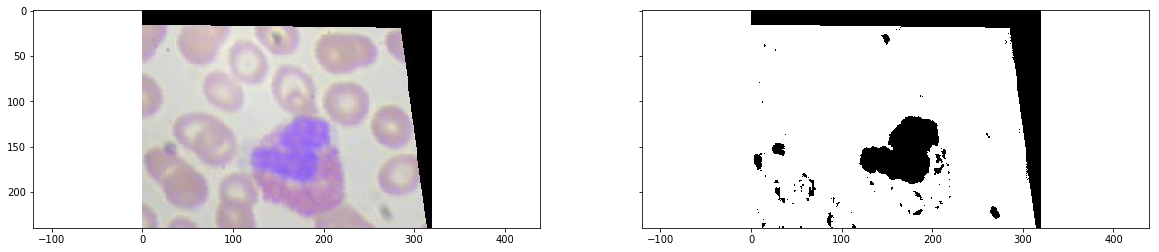

In [153]:
# bin_image will be a (240, 320) True/False array
bin_image = image[:, :, 0] > 180
plot_image([image, bin_image], cmap='gray')

## Normalisation 

To do efficient training on CNN based architecture, Normalisation is one of the most crucial step in the pre-processing part. We will try general normalization (division by 255), min-max based normalization and percentile methods of normalization.

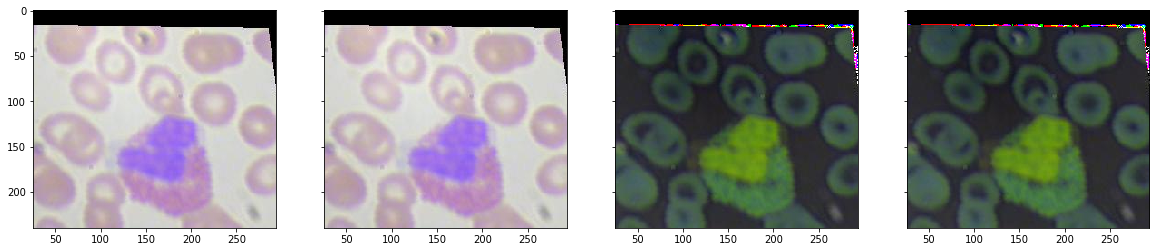

In [132]:
norm1_image = image/255
norm2_image = image - np.min(image)/np.max(image) - np.min(image)
norm3_image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)

plot_image([image, norm1_image, norm2_image, norm3_image], cmap='gray')

##### We can clearly see that simple scaling by 255 retains most of the characteristics of the images

## Augmentations

No need to do image augmentation since we are already provided with the augmented data

# Network Building

Let's now build the network. We will use Resnet-16 architecture as it is predominantly used in medical/healthcare industry for image based networks. Resnet can be extended upto 152 layers but because of system limitations we cannot train more than 18 (18 is de facto minimum layers on which ResNet must be built for decent results

In [137]:
import resnet

# specify image size and channels
img_channels = 3
img_rows = 100
img_cols = 100

# number of classes
nb_classes = 2

### Data Generator ###

Let's now set up a custom **data generator**. T


We have the training data stored in $n$ directories (for $n$ classes). We want to generate batches of data points and feed them to the model.

In training mode, it subsets `paths` to contain the first 80% images; in validation mode it subsets the last 20%. In the special case of an ablation experiment, it simply subsets the first `ablation` images of each class.

In [138]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    
    def __init__(self, mode='train', ablation=None, smear_cls = ['mononuclear', 'polynuclear'], 
                 batch_size=10, dim=(100, 100), n_channels=3, shuffle=True):
        """
        Initialise the data generator
        """
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        
        # glob through directory of each class 
        for i, cls in enumerate(smear_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:ablation]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
            
        self.n_channels = n_channels
        self.n_classes = len(smear_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = io.imread(ID)
            img = img/255
            if img.shape[0] > 100 and img.shape[1] > 100:
                img = resize(img, (100, 100), anti_aliasing=True)
            else:
                delete_rows.append(i)
                continue
            
            X[i,] = img
          
            # Store class
            y[i] = self.labels[ID]
        
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

#### Checking that the network is 'working'

Let's check if the network is working atleast. We will fit the net on only a few images and just one epoch. If we use an ablation of 100 images of each class, so total number of batches is `np.floor(100/32)` = 3. 

In [139]:
# using resnet 18
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy', optimizer='SGD',
              metrics=['accuracy'])

# create data generator objects in train and val mode
# specify ablation=number of data points to train on
training_generator = DataGenerator('train', ablation=100)
validation_generator = DataGenerator('val', ablation=100)

# fit: this will fit the net on 'ablation' samples, only 1 epoch
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=1)

Epoch 1/1
20/20 [==============================] - 39s 2s/step - loss: 1.6582 - acc: 0.4850 - val_loss: 1.6744 - val_acc: 0.5000


The results show that the model is atleast working and is able to learn from a small dataset.
Let's now build the entire network

### Hyperparameter Tuning

Most prominent hyper-parameters to be tuned are:

1. Learning Rate & Variation + Optimisers 
2. Augmentation Techniques (We will not do this since the dataset provided has already been augmented)

We will use callbacks for actions (to capture some information or to execute some procedures) that we want to perform at specific events during training. We will use class `keras.callbacks.Callback`. 

In [140]:
# We will use callbacks for loss history, hence the class LossHistory
# We will create the instance of the class LossHistory called history later and pass it to model.fit_generator using callbacks=[history]
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

#### Let's do the hyperparameter tuning on learning

In [141]:
from keras import optimizers
from keras.callbacks import *
from skimage import io

# range of learning rates to tune
hyper_parameters_for_lr = [0.1, 0.01, 0.001]

# callback to append loss
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

# instantiate a LossHistory() object to store histories
history = LossHistory()
plot_data = {}

# for each hyperparam: train the model and plot loss history
for lr in hyper_parameters_for_lr:
    print ('\n\n'+'=='*20 + '   Checking for LR={}  '.format(lr) + '=='*20 )
    sgd = optimizers.SGD(lr=lr, clipnorm=1.)
    
    # model and generators
    model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
    model.compile(loss='categorical_crossentropy',optimizer= sgd,
                  metrics=['accuracy'])
    training_generator = DataGenerator('train', ablation=100)
    validation_generator = DataGenerator('val', ablation=100)
    model.fit_generator(generator=training_generator,
                        validation_data=validation_generator,
                        epochs=3, callbacks=[history])
    
    # plot loss history
    plot_data[lr] = history.losses



========================================   Checking for LR=0.1  ========================================
Epoch 1/3
20/20 [==============================] - 39s 2s/step - loss: 1.6902 - acc: 0.5350 - val_loss: 1.7572 - val_acc: 0.5000
Epoch 2/3
20/20 [==============================] - 25s 1s/step - loss: 1.6430 - acc: 0.6400 - val_loss: 1.6742 - val_acc: 0.5000
Epoch 3/3
20/20 [==============================] - 24s 1s/step - loss: 1.5569 - acc: 0.6700 - val_loss: 1.6558 - val_acc: 0.5500


========================================   Checking for LR=0.01  ========================================
Epoch 1/3
20/20 [==============================] - 38s 2s/step - loss: 1.6749 - acc: 0.5250 - val_loss: 1.6632 - val_acc: 0.5150
Epoch 2/3
20/20 [==============================] - 24s 1s/step - loss: 1.6419 - acc: 0.5700 - val_loss: 1.6565 - val_acc: 0.4950
Epoch 3/3
20/20 [==============================] - 23s 1s/step - loss: 1.6291 - acc: 0.6100 - val_loss: 1.6567 - val_acc: 0.5150


=========

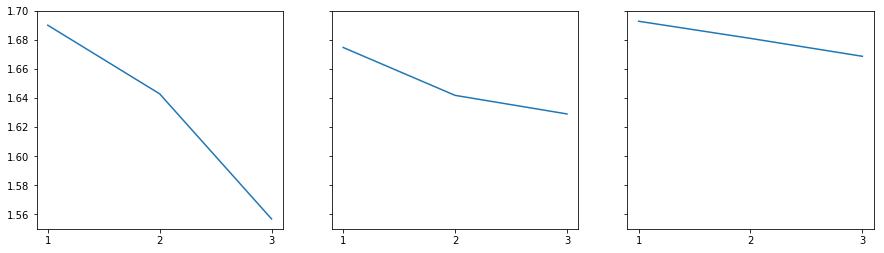

In [142]:
# plot loss history for each value of hyperparameter
f, axes = plt.subplots(1, 3, sharey=True)
f.set_figwidth(15)

plt.setp(axes, xticks=np.arange(0, len(plot_data[0.01]), 1)+1)

for i, lr in enumerate(plot_data.keys()):
    axes[i].plot(np.arange(len(plot_data[lr]))+1, plot_data[lr])

The results above show that a learning rate of 0.01 seems to suite us the best, but doing the training based on learning rate of 0.01 is going to be very slow. So we will start with a learning rate of 0.1 and use learning rate decay - starting from a learning rate of 0.1 and decaying it with every epoch.

For this, we will implement another callback operation (`DecayLR`) while fitting the model.

In [143]:
# learning rate decay
class DecayLR(keras.callbacks.Callback):
    def __init__(self, base_lr=0.001, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    # set lr on_train_begin
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    # change learning rate at the end of epoch
    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

# to store loss history
history = LossHistory()
plot_data = {}

# start with lr=0.1
decay = DecayLR(base_lr=0.1)

In [144]:
# keras data generator
# help(ImageDataGenerator)

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

If you want to implement your own customized data generator (with augmentation), you can add the augmentation step easily to the `DataGenerator` class created above. The only change is that we stack the augmented images to the X, y arrays (as done in the last section of the code below).

### Optimization Metrics

ROC based Area Under Curve (AUC) the metric that we will use for model assessment. Though, we will check the accuracy as well, we will do optimizations based on AUC. Again we will use the callbacks `on_train_begin` and `on_epoch_end` to initialise  (at the start of each epoch) and store the AUC (at the end of epoch).

In [145]:
from sklearn.metrics import roc_auc_score

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc


## Final Run

Let's now train the final model. Note that we will keep saving the best model's weights at `models/bloodsmear_model.h5`in directory `models`. We will again use the callback mechanism for saving the model after every checkpoint. If the model at a checkpoint is better than the one generated at the previous checkpoint, then only it will replace the bloodsmear_model.h5

In [146]:
# model
from skimage import io
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer= 'SGD',
              metrics=['accuracy'])
training_generator = DataGenerator('train')
validation_generator = DataGenerator('val')

# checkpoint - save the best model only if its better after every epoch
filepath = 'models/bloodsmear_model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
auc_logger = roc_callback()

# fit 
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=10, callbacks=[auc_logger, history, decay, checkpoint])


Epoch 1/10
793/793 [==============================] - 874s 1s/step - loss: 1.4397 - acc: 0.7890 - val_loss: 1.5733 - val_acc: 0.7646

Val AUC for epoch0: 0.8426811461852495

Epoch 00001: val_auc improved from -inf to 0.84268, saving model to models/bloodsmear_model.h5
Epoch 2/10


c:\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


793/793 [==============================] - 836s 1s/step - loss: 1.0907 - acc: 0.9337 - val_loss: 2.5838 - val_acc: 0.5778

Val AUC for epoch1: 0.647037200674261

Epoch 00002: val_auc did not improve from 0.84268
Epoch 3/10


c:\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


793/793 [==============================] - 825s 1s/step - loss: 0.9846 - acc: 0.9720 - val_loss: 1.0572 - val_acc: 0.9475

Val AUC for epoch2: 0.9973419750604815

Epoch 00003: val_auc improved from 0.84268 to 0.99734, saving model to models/bloodsmear_model.h5
Epoch 4/10


c:\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


793/793 [==============================] - 851s 1s/step - loss: 0.9184 - acc: 0.9931 - val_loss: 1.0301 - val_acc: 0.9328

Val AUC for epoch3: 0.9999948981465987

Epoch 00004: val_auc improved from 0.99734 to 0.99999, saving model to models/bloodsmear_model.h5
Epoch 5/10


c:\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


793/793 [==============================] - 797s 1s/step - loss: 0.9172 - acc: 0.9913 - val_loss: 0.9141 - val_acc: 0.9894

Val AUC for epoch4: 0.9993643187956545

Epoch 00005: val_auc did not improve from 0.99999
Epoch 6/10


c:\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


793/793 [==============================] - 790s 996ms/step - loss: 0.9023 - acc: 0.9946 - val_loss: 0.8893 - val_acc: 0.9980

Val AUC for epoch5: 0.9999438804715265

Epoch 00006: val_auc did not improve from 0.99999
Epoch 7/10


c:\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


793/793 [==============================] - 848s 1s/step - loss: 0.9008 - acc: 0.9957 - val_loss: 0.8860 - val_acc: 0.9990

Val AUC for epoch6: 0.9999979592586394

Epoch 00007: val_auc improved from 0.99999 to 1.00000, saving model to models/bloodsmear_model.h5
Epoch 8/10


c:\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


793/793 [==============================] - 835s 1s/step - loss: 0.9074 - acc: 0.9941 - val_loss: 0.8863 - val_acc: 0.9985

Val AUC for epoch7: 0.9999979592898737

Epoch 00008: val_auc improved from 1.00000 to 1.00000, saving model to models/bloodsmear_model.h5
Epoch 9/10


c:\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


793/793 [==============================] - 793s 1s/step - loss: 0.9014 - acc: 0.9957 - val_loss: 0.8854 - val_acc: 0.9990

Val AUC for epoch8: 0.9999979592232395

Epoch 00009: val_auc did not improve from 1.00000
Epoch 10/10


c:\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


793/793 [==============================] - 786s 991ms/step - loss: 0.8970 - acc: 0.9958 - val_loss: 0.8849 - val_acc: 0.9990

Val AUC for epoch9: 0.9999979593169426

Epoch 00010: val_auc improved from 1.00000 to 1.00000, saving model to models/bloodsmear_model.h5


### We can see that the accuracy became kind of stagnant after 5-6 epochs. 
### The training and validation accuracy has been very good, ruling out the possibilty of overfitting
### Metric AUC is having a high area, hence the results can be predicted with a high level of confidence
### The loss has dropped gradually during each epoch of training

# Test of a few sample images

In [154]:
#h, w, _ = image_test.shape
image_test = io.imread(r'C:\Users\pankaj.kharwal\Desktop\hackathon\blood-cells\dataset2-master\dataset2-master\images\TEST\LYMPHOCYTE\_0_33.jpeg')
img_resized = resize(image_test, (100, 100), anti_aliasing=True)
model.predict(img_resized[np.newaxis,: ])

c:\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


array([[9.9999857e-01, 1.3794267e-06]], dtype=float32)

In [155]:
#h, w, _ = image_test.shape
image_test = io.imread(r'C:\Users\pankaj.kharwal\Desktop\hackathon\blood-cells\dataset2-master\dataset2-master\images\TEST\EOSINOPHIL\_0_1616.jpeg')
img_resized = resize(image_test, (100, 100), anti_aliasing=True)
model.predict(img_resized[np.newaxis,: ])

array([[0.00340232, 0.9965977 ]], dtype=float32)

### We can clearly see that the model is predicting the images correctly into one of the classes with a high level of accuracy and a very good probability
